In [1]:
%run ../scripts/imports.py

data_path = open("../path_data.txt", 'r').readline()

Succesfully imported libraries and modules



## Creating dataframe with clinics

We need to have patient.updrs property for each patient. It should contain all available UPDRS assessment scores for each day, symptom and side. This property will be saved to each patient.

Also, dataframe with PAC, beta and HFO powers will be complemented with these scores. 
Needed properties: updrs_left_brady; updrs_left_rigidity; updrs_left_tremor

Предлагаю создать словарь со словарями:
condition: {left_bradyk: int, left_rigid: int, left_tremor: int, ...}

In [20]:
conditions_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

conditions = [c for c in conditions_rest if c in patient.conditions]
clinics_keys = ["r_brady", "r_rigid", "r_tremor", "l_brady", "l_rigid", "l_tremor"]

df_new = pd.DataFrame(columns=clinics_keys, index=conditions)

clinics = defaultdict(dict)

for column in list(df.columns):
    ldopa = "OFF" if 'off' in column else 'ON'
    for day in list(df.index):
        if 'Day' not in day:
            continue
        condition = create_condition_name(day, ldopa, 'Rest 180sec')
        # side
        side = 'r' if "Right" in column else 'l'
        # symptom
        if "Brady" in column:
            key = side + '_brady'
        if "Rigid" in column:
            key = side + '_rigid'
        if "Tremor" in column:
            key = side + '_tremor'
        value = df.loc[day][column]
        clinics[condition][key] = value
        df_new.loc[condition][key] = value
        
        

In [21]:
df_new

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor
1Day OFF Rest 180sec,8,5,3,8,6,2
1Day ON Rest 180sec,4,1,0,3,2,0
5Day OFF Rest 180sec,13,7,3,9,5,2
5Day ON Rest 180sec,2,2,0,2,2,0


In [23]:
patient.clinics = df_new
patient.save()

Saving Patient1 object to D:\LAB\AlexPAC\data\Patient1\Patient1.pkl ...
Pickling Patient1 without ['pac']
Done, 2.187581777572632 sec
File size: 2788.229974746704 MB
Returning filepath for saved file


'D:\\LAB\\AlexPAC\\data\\Patient1\\Patient1.pkl'

### ADD l_mean_cross_pac and l_mean_inter_pac (as well as probably beta and hfo scores) to this table

In [3]:
df_power = pd.read_csv('../data/beta_hfo_pac_powers_REST.csv', sep=',', index_col=0)

In [4]:
df_power['side'] = df_power['phase'].apply(lambda s: s[0])

In [5]:
df_power.head()

,patient,condition,phase,amplitude,beta_power,hfo_power,pac_power_p2,pac_power_p09,is_cross_pac,ldopa,side
0,Patient1,1Day ON Rest 180sec,R1-2A,R1-2A,0.471097,0.001178,0.0,0.0,0,ON,R
1,Patient1,1Day ON Rest 180sec,R1-2A,R4-3B,0.471097,0.001514,0.0,0.0,1,ON,R
2,Patient1,1Day ON Rest 180sec,R1-2A,R1-2B,0.471097,0.000648,0.0,0.0,1,ON,R
3,Patient1,1Day ON Rest 180sec,R1-2A,R4-3C,0.471097,0.001486,0.0,0.0,1,ON,R
4,Patient1,1Day ON Rest 180sec,R1-2A,R2B-3B,0.471097,0.000949,0.0,0.0,1,ON,R


In [37]:
#def get_mean_cross_pac(patient, condition):
df_patient = df_power[df_power.patient == patient.name]
df_condition = df_patient[df_patient.condition == condition]
print(df_condition.groupby('is_cross_pac').mean())

l_mean_cross_pac = df_condition[(df_condition.side == 'L') & (df_condition.is_cross_pac == 1)]['pac_power'].mean()
l_mean_cross_pac

              beta_power  hfo_power  pac_power
is_cross_pac                                  
0               0.404905   0.000407   0.000059
1               0.392046   0.000438   0.000058


1.902310745704486e-05

In [2]:
def get_mean_pac_values(patient, condition, pac_power_type='p2'):
    df_patient = df_power[df_power.patient == patient.name]
    df_cond = df_patient[df_patient.condition == condition]
    
    l_mean_cross_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 1)]['pac_power_p2'].mean()
    r_mean_cross_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 1)]['pac_power_p2'].mean()
    l_mean_inter_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 0)]['pac_power_p2'].mean()
    r_mean_inter_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 0)]['pac_power_p2'].mean()
    
    return l_mean_cross_pac, l_mean_inter_pac, r_mean_cross_pac, r_mean_inter_pac

def get_max_pac_values(patient, condition, pac_power_type='p2'):
    df_patient = df_power[df_power.patient == patient.name]
    df_cond = df_patient[df_patient.condition == condition]
    
    l_max_cross_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 1)]['pac_power_p2'].max()
    r_max_cross_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 1)]['pac_power_p2'].max()
    l_max_inter_pac = df_cond[(df_cond.side == 'L') & (df_cond.is_cross_pac == 0)]['pac_power_p2'].max()
    r_max_inter_pac = df_cond[(df_cond.side == 'R') & (df_cond.is_cross_pac == 0)]['pac_power_p2'].max()
    
    return l_max_cross_pac, l_max_inter_pac, r_max_cross_pac, r_max_inter_pac


def get_pac_value_for_condition(df_power, patient, condition, side='l', metric='mean', pac_type='inter', pac_power_type='p2'):
    """ Returns feature name and value """
    new_side = 'L' if side == 'l' else 'R'
    is_cross_pac = 1 if pac_type == 'cross' else 0
    
    df_patient = df_power[df_power.patient == patient.name]
    df_cond = df_patient[df_patient.condition == condition]
    
    if metric == 'mean':
        val = df_cond[(df_cond.side == new_side) & (df_cond.is_cross_pac == is_cross_pac)][f"pac_power_{pac_power_type}"].mean()
    if metric == 'max':
        val = df_cond[(df_cond.side == new_side) & (df_cond.is_cross_pac == is_cross_pac)][f'pac_power_{pac_power_type}'].max()
        
    feature_name = '_'.join([side, metric, pac_type, 'pac'])
    
    return feature_name, val


def get_beta_value_for_condition(df_power, patient, condition, side='l'):
    """ Returns feature name and value """
    new_side = 'L' if side == 'l' else 'R'
    
    df_patient = df_power[df_power.patient == patient.name]
    df_cond = df_patient[df_patient.condition == condition]
    
    val = df_cond[(df_cond.side == new_side)]["beta_power"].mean()
        
    feature_name = '_'.join([side, 'mean', 'beta'])
    
    return feature_name, val

In [41]:
clinics_with_pac = df_new.copy()
pac_columns = ['l_mean_inter_pac', 'l_mean_cross_pac', 'r_mean_inter_pac', 'r_mean_cross_pac', \
               'l_max_inter_pac', 'l_max_cross_pac', 'r_max_inter_pac', 'r_max_cross_pac']

for column in pac_columns:
    clinics_with_pac[column] = np.nan

for condition in conditions:
    for side in ['l', 'r']:
        for pac_type in ['cross', 'inter']:
            for metric in ['max', 'mean']:
                column, value = get_pac_value_for_condition(df_power, patient, condition, side, metric, pac_type, pac_power_type='p2')
                clinics_with_pac.loc[condition, column] = value
    
#     l_mean_cross_pacs.append(l_mean_cross_pac)
#     r_mean_cross_pacs.append(r_mean_cross_pac)
#     l_mean_inter_pacs.append(l_mean_inter_pac)
#     r_mean_inter_pacs.append(r_mean_inter_pac)
    
# pac_dict = {name: values for name, values in zip(pac_columns, [l_mean_cross_pacs, l_mean_inter_pacs, r_mean_cross_pacs, r_mean_inter_pacs])}

# for column in pac_columns:
#     clinics_with_pac[column] = pac_dict[column]
    
patient.clinics_with_pac = clinics_with_pac

In [42]:
clinics_with_pac

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac
1Day OFF Rest 180sec,6,2,3,12,6,5,0.000042,0.000052,0.000043,0.000029,0.000193,0.000279,0.000286,0.000225
1Day ON Rest 180sec,1,0,0,3,2,0,0.000055,0.000048,0.000028,0.000022,0.000249,0.000475,0.000152,0.000195


In [3]:
patients = [load_patient(i, data_path, load_pac=True) for i in range(1, 10)]

Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient1
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient2
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient3
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient4
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient5
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient6
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient7
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient8
Patient directory:  C:\Users\aleks\Downloads\data_pac\Patient9


### Adding PAC powers to patient.clinics dataframe

In [16]:
clinics_with_pac_list = []
df_power = pd.read_csv('../data/beta_hfo_pac_powers_REST.csv', sep=',', index_col=0)
df_power['side'] = df_power['phase'].apply(lambda s: s[0])

conditions_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]
clinics_keys = ["r_brady", "r_rigid", "r_tremor", "l_brady", "l_rigid", "l_tremor"]

for patient in patients:

    clinics_with_pac = patient.clinics.copy()
    pac_columns = ['l_mean_inter_pac', 'l_mean_cross_pac', 'r_mean_inter_pac', 'r_mean_cross_pac', \
               'l_max_inter_pac', 'l_max_cross_pac', 'r_max_inter_pac', 'r_max_cross_pac']

    for column in pac_columns:
        clinics_with_pac[column] = np.nan  
    
    beta_columns = ['l_mean_beta', 'r_mean_beta']

    for column in pac_columns:
        clinics_with_pac[column] = np.nan

        
    conditions = [c for c in conditions_rest if c in patient.conditions]
    for condition in conditions:
        for side in ['l', 'r']:
            for pac_type in ['cross', 'inter']:
                for metric in ['max', 'mean']:
                    column, value = get_pac_value_for_condition(df_power, 
                                                                patient, 
                                                                condition, 
                                                                side, 
                                                                metric, 
                                                                pac_type, 
                                                                pac_power_type='p2')
                    clinics_with_pac.loc[condition, column] = value
            # getting beta power values
            column, value = get_beta_value_for_condition(df_power, patient, condition, side)
            clinics_with_pac.loc[condition, column] = value

    patient.clinics_with_pac = clinics_with_pac
    # print("\n\n")
    # print(clinics_with_pac)
    # print("\n\n")
    #patient.save()
    clinics_with_pac_list.append(clinics_with_pac)

for i, df in enumerate(clinics_with_pac_list):
    df['patient'] = patients[i].name
    
df_clinics_with_pac = pd.concat(clinics_with_pac_list, ignore_index=True)
df_clinics_with_pac.to_csv('../data/clinics_with_pac.csv', sep=',')

In [17]:
df_clinics_with_pac

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,l_mean_beta,r_mean_beta,patient
0,8,5,3,8,6,2,0.000033,0.000024,0.000140,0.000085,0.000149,0.000294,0.000375,0.000467,0.640228,0.862501,Patient1
1,4,1,0,3,2,0,0.000010,0.000027,0.000030,0.000071,0.000148,0.000631,0.000293,0.000509,0.160282,0.313372,Patient1
2,13,7,3,9,5,2,0.000058,0.000149,0.000347,0.000379,0.000562,0.000649,0.000945,0.000952,1.019175,1.267418,Patient1
3,2,2,0,2,2,0,0.000032,0.000019,0.000086,0.000098,0.000190,0.000237,0.000441,0.000386,0.327043,0.461483,Patient1
4,7,4,0,10,6,0,0.000110,0.000056,0.000152,0.000146,0.000550,0.000613,0.000658,0.000788,0.688565,0.710451,Patient2
5,2,2,0,6,4,0,0.000124,0.000065,0.000117,0.000130,0.000665,0.000738,0.000487,0.000589,0.628981,0.747639,Patient2
6,5,4,0,6,6,0,0.000407,0.000438,0.000158,0.000064,0.001264,0.001501,0.000819,0.000591,1.082613,1.000805,Patient2
7,0,1,0,1,1,0,0.000077,0.000090,0.000065,0.000013,0.000304,0.000404,0.000213,0.000215,0.280065,0.314866,Patient2
8,3,6,0,2,5,0,0.000323,0.000312,0.000098,0.000088,0.001721,0.001422,0.000445,0.000475,0.915511,0.792442,Patient3
9,1,1,0,0,1,0,0.000009,0.000033,0.000097,0.000090,0.000132,0.000294,0.000323,0.000345,0.373357,0.380807,Patient3


### Calculate same dataframes for each patient available

In [8]:
clinics_with_pac_list = []

for patient in [p1, p2, p3, p4, p5, p6]:
    
    df = pd.read_excel(os.path.join(patient.root_dir, f"{patient.name}_clinics.xls"), index_col=0)

    conditions_rest = ["1Day OFF Rest 180sec", "1Day ON Rest 180sec", "5Day OFF Rest 180sec", "5Day ON Rest 180sec"]

    conditions = [c for c in conditions_rest if c in patient.conditions]
    clinics_keys = ["r_brady", "r_rigid", "r_tremor", "l_brady", "l_rigid", "l_tremor"]

    df_new = pd.DataFrame(columns=clinics_keys, index=conditions)

    clinics = defaultdict(dict)

    for column in list(df.columns):
        ldopa = "OFF" if 'off' in column else 'ON'
        for day in list(df.index):
            if 'Day' not in day:
                continue
            condition = create_condition_name(day, ldopa, 'Rest 180sec')
            # side
            side = 'r' if "Right" in column else 'l'
            # symptom
            if "Brady" in column:
                key = side + '_brady'
            if "Rigid" in column:
                key = side + '_rigid'
            if "Tremor" in column:
                key = side + '_tremor'
            value = df.loc[day][column]
            clinics[condition][key] = value
            df_new.loc[condition][key] = value

    patient.clinics = df_new

    df_power = pd.read_csv('beta_hfo_pac_powers_REST.csv', sep=',', index_col=0)
    df_power['side'] = df_power['phase'].apply(lambda s: s[0])


    clinics_with_pac = df_new.copy()
    pac_columns = ['l_mean_inter_pac', 'l_mean_cross_pac', 'r_mean_inter_pac', 'r_mean_cross_pac', \
               'l_max_inter_pac', 'l_max_cross_pac', 'r_max_inter_pac', 'r_max_cross_pac']

    for column in pac_columns:
        clinics_with_pac[column] = np.nan
        
    
    beta_columns = ['l_mean_beta', 'r_mean_beta']

    for column in pac_columns:
        clinics_with_pac[column] = np.nan

    for condition in conditions:
        for side in ['l', 'r']:
            for pac_type in ['cross', 'inter']:
                for metric in ['max', 'mean']:
                    column, value = get_pac_value_for_condition(df_power, 
                                                                patient, 
                                                                condition, 
                                                                side, 
                                                                metric, 
                                                                pac_type, 
                                                                pac_power_type='p2')
                    clinics_with_pac.loc[condition, column] = value
            # getting beta power values
            column, value = get_beta_value_for_condition(df_power, patient, condition, side)
            clinics_with_pac.loc[condition, column] = value

    patient.clinics_with_pac = clinics_with_pac
    #patient.save()
    clinics_with_pac_list.append(clinics_with_pac)
    
patients = [p1, p2, p3, p4, p5, p6]

for i, df in enumerate(clinics_with_pac_list):
    df['patient'] = patients[i].name
    
df_clinics_with_pac = pd.concat(clinics_with_pac_list, ignore_index=True)
df_clinics_with_pac.to_csv('../data/clinics_with_pac.csv', sep=',')

In [9]:
df_clinics_with_pac

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,l_mean_beta,r_mean_beta,patient
0,8,5,3,8,6,2,0.000033,0.000024,0.000140,0.000085,0.000149,0.000294,0.000375,0.000467,0.640228,0.862501,Patient1
1,4,1,0,3,2,0,0.000010,0.000027,0.000030,0.000071,0.000148,0.000631,0.000293,0.000509,0.160282,0.313372,Patient1
2,13,7,3,9,5,2,0.000058,0.000149,0.000347,0.000379,0.000562,0.000649,0.000945,0.000952,1.019175,1.267418,Patient1
3,2,2,0,2,2,0,0.000032,0.000019,0.000086,0.000098,0.000190,0.000237,0.000441,0.000386,0.327043,0.461483,Patient1
4,NaN,NaN,NaN,NaN,NaN,NaN,0.000110,0.000056,0.000152,0.000146,0.000550,0.000613,0.000658,0.000788,0.688565,0.710451,Patient2
5,NaN,NaN,NaN,NaN,NaN,NaN,0.000124,0.000065,0.000117,0.000130,0.000665,0.000738,0.000487,0.000589,0.628981,0.747639,Patient2
6,5,4,0,6,6,0,0.000407,0.000438,0.000158,0.000064,0.001264,0.001501,0.000819,0.000591,1.082613,1.000805,Patient2
7,0,1,0,1,1,0,0.000077,0.000090,0.000065,0.000013,0.000304,0.000404,0.000213,0.000215,0.280065,0.314866,Patient2
8,3,6,0,2,5,0,0.000323,0.000312,0.000098,0.000088,0.001721,0.001422,0.000445,0.000475,0.915511,0.792442,Patient3
9,1,1,0,0,1,0,0.000009,0.000033,0.000097,0.000090,0.000132,0.000294,0.000323,0.000345,0.373357,0.380807,Patient3


### Get global clinics and PAC table

In [11]:
patients = [p1, p2, p3, p4, p5, p6]

for i, df in enumerate(clinics_with_pac_list):
    df['patient'] = patients[i].name

In [12]:
df_clinics_with_pac = pd.concat(clinics_with_pac_list, ignore_index=True)

In [13]:
df_clinics_with_pac.to_csv('clinics_with_pac.csv', sep=',')

In [14]:
df = df_clinics_with_pac.dropna()

In [15]:
df.head(20)

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,patient
0,8,5,3,8,6,2,0.000033,0.000024,0.000140,0.000085,0.000149,0.000294,0.000375,0.000467,Patient1
1,4,1,0,3,2,0,0.000010,0.000027,0.000030,0.000071,0.000148,0.000631,0.000293,0.000509,Patient1
2,13,7,3,9,5,2,0.000058,0.000149,0.000347,0.000379,0.000562,0.000649,0.000945,0.000952,Patient1
3,2,2,0,2,2,0,0.000032,0.000019,0.000086,0.000098,0.000190,0.000237,0.000441,0.000386,Patient1
6,5,4,0,6,6,0,0.000407,0.000438,0.000158,0.000064,0.001264,0.001501,0.000819,0.000591,Patient2
7,0,1,0,1,1,0,0.000077,0.000090,0.000065,0.000013,0.000304,0.000404,0.000213,0.000215,Patient2
8,3,6,0,2,5,0,0.000323,0.000312,0.000098,0.000088,0.001721,0.001422,0.000445,0.000475,Patient3
9,1,1,0,0,1,0,0.000009,0.000033,0.000097,0.000090,0.000132,0.000294,0.000323,0.000345,Patient3
10,12,4,2,10,6,2,0.000335,0.000218,0.000258,0.000164,0.001125,0.001316,0.001247,0.001208,Patient3
11,0,1,0,0,2,0,0.000214,0.000133,0.000180,0.000065,0.000839,0.000670,0.000809,0.000683,Patient3


In [8]:
df.corr()

,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,l_mean_beta,r_mean_beta
l_mean_inter_pac,1.000000,0.586795,0.237125,0.144636,0.601864,0.522064,0.186460,0.138501,0.843621,0.469214
l_mean_cross_pac,0.586795,1.000000,0.924415,0.885824,0.845386,0.993059,0.904854,0.880569,0.308974,0.989743
r_mean_inter_pac,0.237125,0.924415,1.000000,0.995034,0.702547,0.951441,0.997748,0.994724,0.005016,0.964720
r_mean_cross_pac,0.144636,0.885824,0.995034,1.000000,0.675054,0.916707,0.999047,0.998490,-0.092828,0.939604
l_max_inter_pac,0.601864,0.845386,0.702547,0.675054,1.000000,0.782765,0.701530,0.641857,0.116724,0.838274
l_max_cross_pac,0.522064,0.993059,0.951441,0.916707,0.782765,1.000000,0.931816,0.916719,0.289562,0.989769
r_max_inter_pac,0.186460,0.904854,0.997748,0.999047,0.701530,0.931816,1.000000,0.996721,-0.061079,0.953620
r_max_cross_pac,0.138501,0.880569,0.994724,0.998490,0.641857,0.916719,0.996721,1.000000,-0.071054,0.932862
l_mean_beta,0.843621,0.308974,0.005016,-0.092828,0.116724,0.289562,-0.061079,-0.071054,1.000000,0.174784
r_mean_beta,0.469214,0.989743,0.964720,0.939604,0.838274,0.989769,0.953620,0.932862,0.174784,1.000000


In [32]:
df

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac
0,8,5,3,8,6,2,0.000064,0.000054,0.000503,0.000252,0.000289,0.000771,0.002129,0.001712
1,4,1,0,3,2,0,0.000029,0.000057,0.000112,0.000155,0.000434,0.001224,0.001155,0.001858
2,13,7,3,9,5,2,0.000303,0.000563,0.002055,0.001969,0.003234,0.003878,0.010972,0.011794
3,2,2,0,2,2,0,0.000071,0.000042,0.000408,0.000324,0.000492,0.000643,0.002797,0.002199
6,5,4,0,6,6,0,0.004402,0.004237,0.001014,0.000214,0.020389,0.025126,0.007771,0.003547
7,0,1,0,1,1,0,0.000221,0.000215,0.000117,0.000028,0.001319,0.001228,0.000411,0.000565
8,3,6,0,2,5,0,0.002980,0.002310,0.000367,0.000259,0.019398,0.017537,0.002196,0.002184
9,1,1,0,0,1,0,0.000017,0.000078,0.000287,0.000273,0.000258,0.001232,0.001421,0.001323
10,12,4,2,10,6,2,0.001967,0.001178,0.001688,0.000864,0.010256,0.011837,0.013612,0.012063
11,0,1,0,0,2,0,0.001106,0.000501,0.001068,0.000201,0.007126,0.005350,0.007023,0.003288


In [145]:
df[df.columns[:-1]] = df[df.columns[:-1]].astype(float)

C:\Users\aleks\anaconda3\envs\pac\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [74]:
df.corr()

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac
r_brady,1.000000,0.749616,0.820667,0.856962,0.502953,0.640687,-0.056388,-0.109416,0.465364,0.313172
r_rigid,0.749616,1.000000,0.746203,0.616028,0.758858,0.618853,0.112835,0.036249,0.583259,0.526731
r_tremor,0.820667,0.746203,1.000000,0.660056,0.584838,0.835619,-0.251074,-0.278209,0.556608,0.568856
l_brady,0.856962,0.616028,0.660056,1.000000,0.595247,0.677744,0.265642,0.226855,0.410515,0.218351
l_rigid,0.502953,0.758858,0.584838,0.595247,1.000000,0.649353,0.397801,0.404270,0.449096,0.632471
l_tremor,0.640687,0.618853,0.835619,0.677744,0.649353,1.000000,-0.035621,-0.036906,0.693210,0.657468
l_mean_inter_pac,-0.056388,0.112835,-0.251074,0.265642,0.397801,-0.035621,1.000000,0.968919,0.071956,0.075817
l_mean_cross_pac,-0.109416,0.036249,-0.278209,0.226855,0.404270,-0.036906,0.968919,1.000000,-0.012388,0.081767
r_mean_inter_pac,0.465364,0.583259,0.556608,0.410515,0.449096,0.693210,0.071956,-0.012388,1.000000,0.779596
r_mean_cross_pac,0.313172,0.526731,0.568856,0.218351,0.632471,0.657468,0.075817,0.081767,0.779596,1.000000


In [12]:
df

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,l_mean_beta,r_mean_beta,patient
0,8.0,5.0,3.0,8.0,6.0,2.0,0.000033,0.000024,0.000140,0.000085,0.000149,0.000294,0.000375,0.000467,0.640228,0.862501,Patient1
1,4.0,1.0,0.0,3.0,2.0,0.0,0.000010,0.000027,0.000030,0.000071,0.000148,0.000631,0.000293,0.000509,0.160282,0.313372,Patient1
2,13.0,7.0,3.0,9.0,5.0,2.0,0.000058,0.000149,0.000347,0.000379,0.000562,0.000649,0.000945,0.000952,1.019175,1.267418,Patient1
3,2.0,2.0,0.0,2.0,2.0,0.0,0.000032,0.000019,0.000086,0.000098,0.000190,0.000237,0.000441,0.000386,0.327043,0.461483,Patient1
6,5.0,4.0,0.0,6.0,6.0,0.0,0.000407,0.000438,0.000158,0.000064,0.001264,0.001501,0.000819,0.000591,1.082613,1.000805,Patient2
7,0.0,1.0,0.0,1.0,1.0,0.0,0.000077,0.000090,0.000065,0.000013,0.000304,0.000404,0.000213,0.000215,0.280065,0.314866,Patient2
8,3.0,6.0,0.0,2.0,5.0,0.0,0.000323,0.000312,0.000098,0.000088,0.001721,0.001422,0.000445,0.000475,0.915511,0.792442,Patient3
9,1.0,1.0,0.0,0.0,1.0,0.0,0.000009,0.000033,0.000097,0.000090,0.000132,0.000294,0.000323,0.000345,0.373357,0.380807,Patient3
10,12.0,4.0,2.0,10.0,6.0,2.0,0.000335,0.000218,0.000258,0.000164,0.001125,0.001316,0.001247,0.001208,0.989552,0.895886,Patient3
11,0.0,1.0,0.0,0.0,2.0,0.0,0.000214,0.000133,0.000180,0.000065,0.000839,0.000670,0.000809,0.000683,0.597046,0.650039,Patient3


In [23]:
df * 10000

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,l_mean_beta,r_mean_beta,patient
0,80000,50000,30000,80000,60000,20000,0.330933,0.236546,1.397207,0.854790,1.485742,2.935139,3.754416,4.668979,6402.284028,8625.008156,Patient1Patient1Patient1Patient1Patient1Patien...
1,40000,10000,0,30000,20000,0,0.098964,0.271047,0.304739,0.711255,1.484467,6.312969,2.934970,5.091519,1602.821626,3133.723302,Patient1Patient1Patient1Patient1Patient1Patien...
2,130000,70000,30000,90000,50000,20000,0.580215,1.492030,3.473683,3.785238,5.619163,6.494975,9.449859,9.516108,10191.751220,12674.182023,Patient1Patient1Patient1Patient1Patient1Patien...
3,20000,20000,0,20000,20000,0,0.324414,0.190231,0.863872,0.979742,1.901303,2.368985,4.412950,3.855566,3270.433997,4614.832960,Patient1Patient1Patient1Patient1Patient1Patien...
4,70000,40000,0,100000,60000,0,1.099975,0.559797,1.519988,1.459816,5.497475,6.130061,6.582544,7.877009,6885.646036,7104.510157,Patient2Patient2Patient2Patient2Patient2Patien...
5,20000,20000,0,60000,40000,0,1.240887,0.646095,1.170741,1.298020,6.646232,7.381769,4.870172,5.886994,6289.810392,7476.389415,Patient2Patient2Patient2Patient2Patient2Patien...
6,50000,40000,0,60000,60000,0,4.071554,4.377344,1.577941,0.640712,12.641166,15.014613,8.192998,5.910351,10826.129926,10008.047007,Patient2Patient2Patient2Patient2Patient2Patien...
7,0,10000,0,10000,10000,0,0.774896,0.899207,0.653036,0.129658,3.038894,4.035505,2.134820,2.150408,2800.653891,3148.657965,Patient2Patient2Patient2Patient2Patient2Patien...
8,30000,60000,0,20000,50000,0,3.230242,3.118398,0.976398,0.878058,17.206845,14.219110,4.453506,4.746198,9155.114051,7924.416437,Patient3Patient3Patient3Patient3Patient3Patien...
9,10000,10000,0,0,10000,0,0.087940,0.331515,0.966280,0.901876,1.319105,2.940438,3.233534,3.445446,3733.570809,3808.065952,Patient3Patient3Patient3Patient3Patient3Patien...


## Mean PAC-clinics correlation (inter and cross separately)

In [34]:
mpl.colormaps

AttributeError: module 'matplotlib' has no attribute 'colormaps'

In [72]:
import matplotlib as mpl

def get_discrete_colors(n_colors, display=False):
    """
    Gets discrete colors for e.g. different labels in the clusters
    Accepts maximum number of 20 n_colors
    """
    assert n_colors < 21, "Maximal number of colors is 20!"
    
    # get colors from a nice cmap
    cm = plt.get_cmap("tab20b")
    colors = [cm(i)[:3] for i in range(20)]
    
    # change the ordering of colors to a nice one
    colors = np.array(colors).reshape(5, 4, 3)
    colors = np.swapaxes(colors, 0, 1)
    colors = colors.reshape((20, 3))
    
    # brighter colors first and then darker ugly ones
    colors = np.concatenate((colors[5:], colors[:5]), axis=0)
    colors = colors[:int(n_colors)]
    if display:
        plt.imshow(colors.reshape((1, n_colors, 3)))
    return colors

In [69]:
colors = df.color.values
np.concatenate((colors, colors)).shape

(68,)

In [95]:
patients_all = patients.copy()

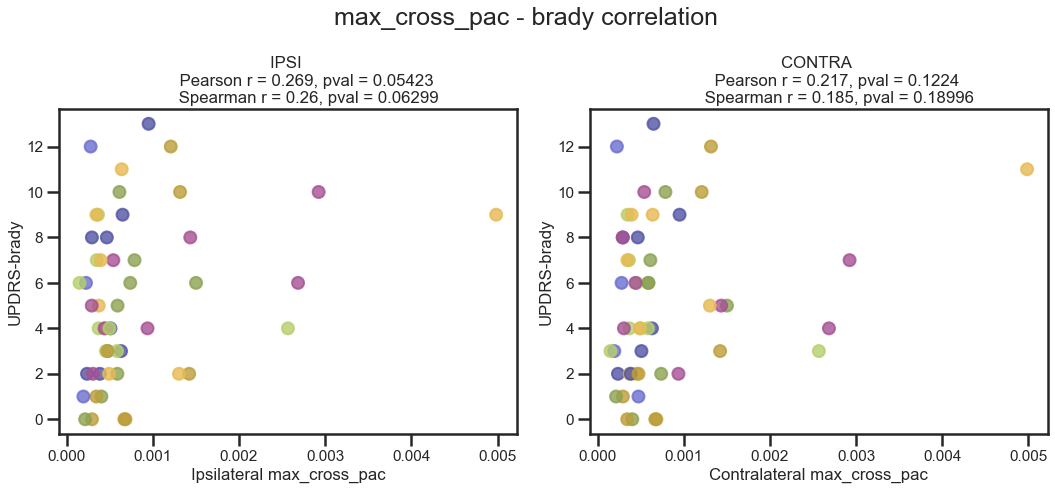

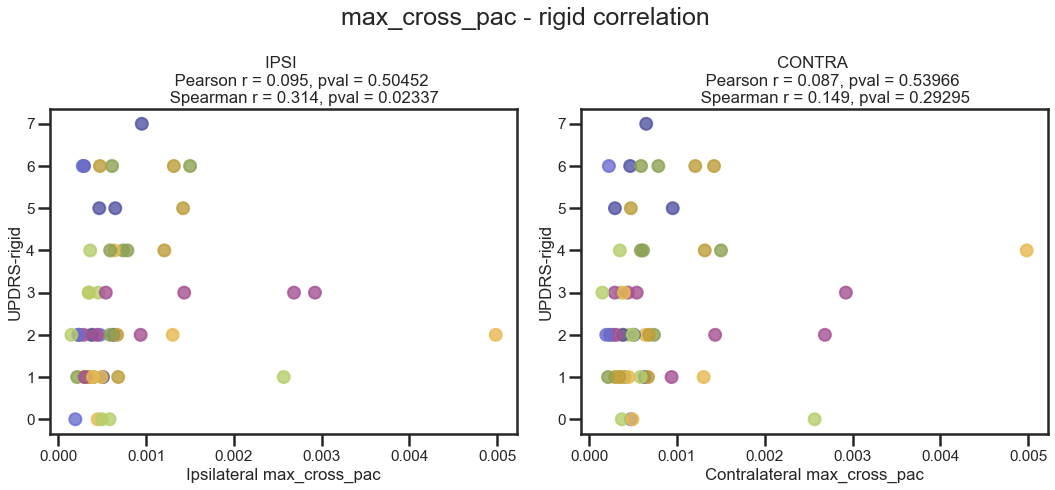

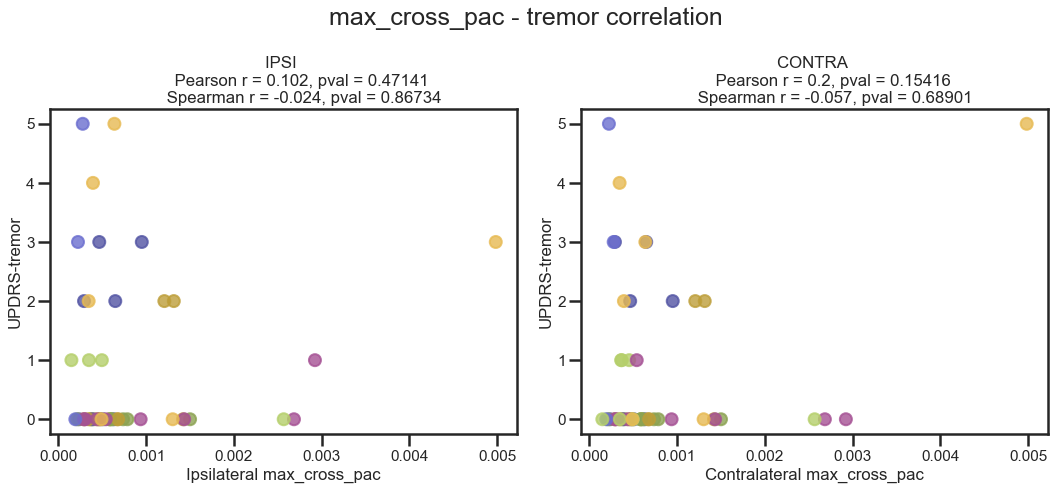

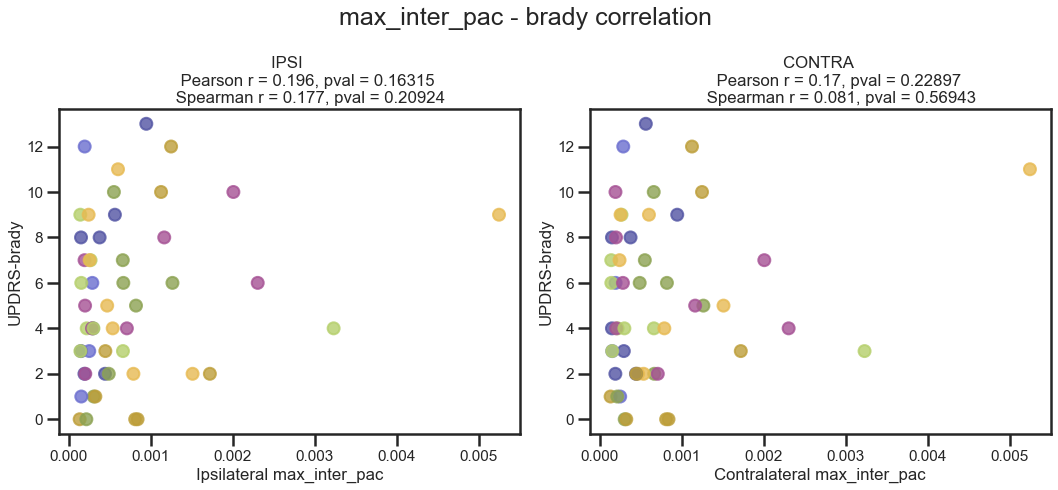

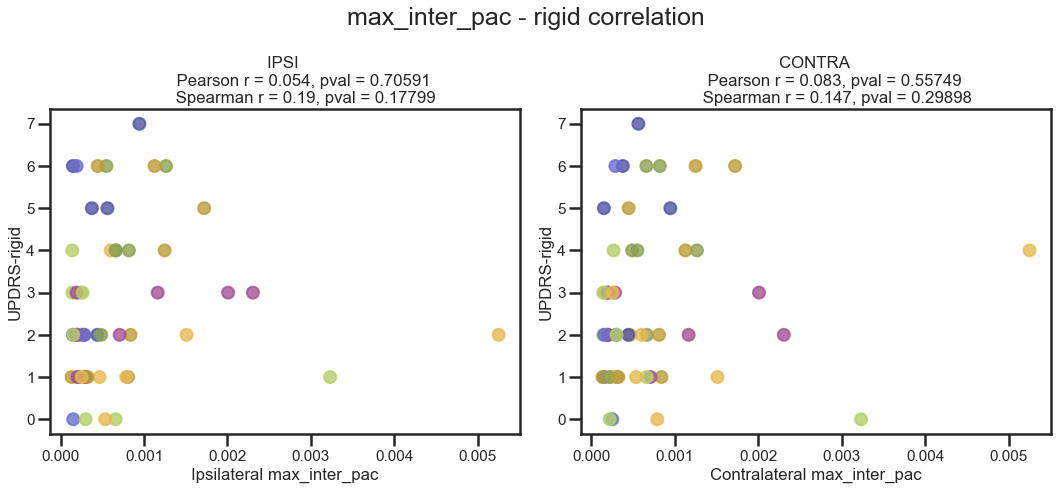

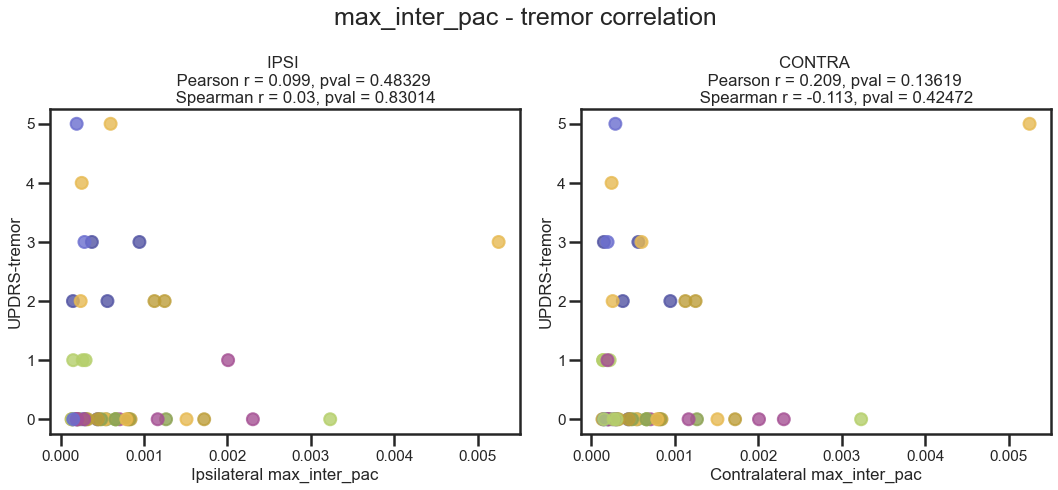

In [104]:
df = pd.read_csv("../data/clinics_with_pac.csv", sep=',', index_col=0)
df = df.dropna()

df = df[(df.patient != "Patient4") & (df.patient != "Patient8")]
patients = [p for p in patients_all if p.name != "Patient8" and p.name != "Patient 4"]

patient_names = [p.name for p in patients]
patient_colors_list = get_discrete_colors(len(patients))
patient_colors = {name: color for name, color in zip(patient_names, patient_colors_list)}
df['color'] = df.patient.apply(lambda name: patient_colors[name])
colors = df.color.values
colors_double = np.concatenate((colors, colors))
df_patients = pd.concat((df.patient, df.patient), ignore_index=True)
alpha = 0.8

sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')

with open('../path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'PAC and clinics correlation')

os.makedirs(save_path, exist_ok=True)

sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]


counter = 1
for pac_type in ['max_cross_pac', 'max_inter_pac']:
    for symptom in ['brady', 'rigid', 'tremor']:
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        plt.suptitle(f"{pac_type} - {symptom} correlation ", fontsize=25)
        
        """IPSILATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        ax = axes[0]
        title = f"IPSI \n \
        Pearson r = {round(rho_p, 3)}, pval = {round(pval_p, 5)} \n \
        Spearman r = {round(rho_s, 3)}, pval = {round(pval_s, 5)}"
        
        ax.scatter(x, y, alpha=alpha, c=colors_double)
        ax.set_title(title)
        ax.set_xlabel(f"Ipsilateral {pac_type}")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        
        
        """CONTRALATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[1]}_{symptom}"]

        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        
        ax = axes[1]
        title = f"CONTRA \n \
        Pearson r = {round(rho_p, 3)}, pval = {round(pval_p, 5)} \n \
        Spearman r = {round(rho_s, 3)}, pval = {round(pval_s, 5)}"
        ax.scatter(x, y, alpha=alpha, c=colors_double)
        ax.set_title(title)
        ax.set_xlabel(f"Contralateral {pac_type}")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        plt.tight_layout()
        
        fig_path = os.path.join(save_path, f"{counter}. {pac_type}-{symptom}.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
        plt.show()
        counter += 1

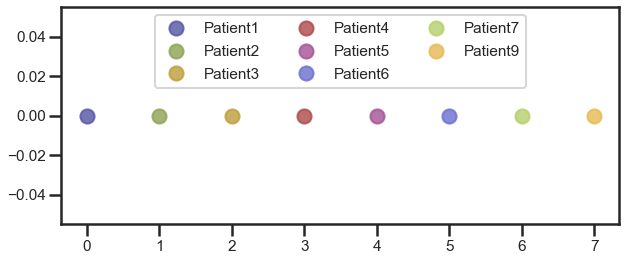

In [99]:
plt.figure(figsize=(10, 4))
for i, patient in enumerate(patients):
    plt.scatter(i, 0, s=200, label=patient.name, color=patient_colors[patient.name], alpha=alpha)
    plt.legend(loc='upper center', handleheight=1, ncol=3)

IndexError: list index out of range

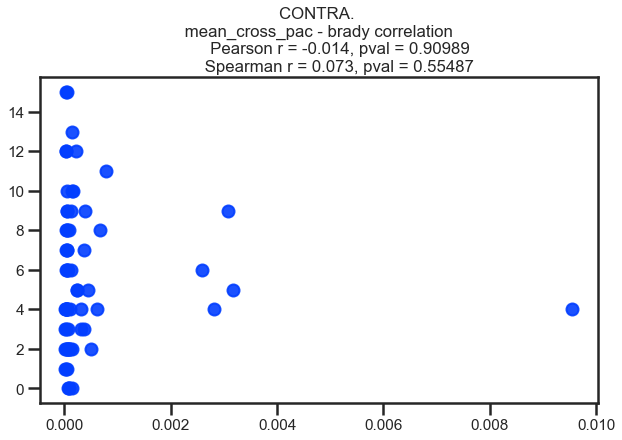

In [101]:
df = pd.read_csv("../data/clinics_with_pac.csv", sep=',', index_col=0)
df = df.dropna()

sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]

# IPSI

for pac_type in ['mean_cross_pac', 'mean_inter_pac']:
    for symptom in ['brady', 'rigid', 'tremor']:
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        title = f"CONTRA. \n {pac_type} - {symptom} correlation \n  \
        Pearson r = {round(rho_p, 3)}, pval = {round(pval_p, 5)} \n \
        Spearman r = {round(rho_s, 3)}, pval = {round(pval_s, 5)}"
        plt.scatter(x, y, alpha=0.9)
        plt.title(title)
        plt.xlabel(f"{sides[i]}_{pac_type}")
        plt.ylabel(f"{sides[i]}_{symptom}")
        plt.show()

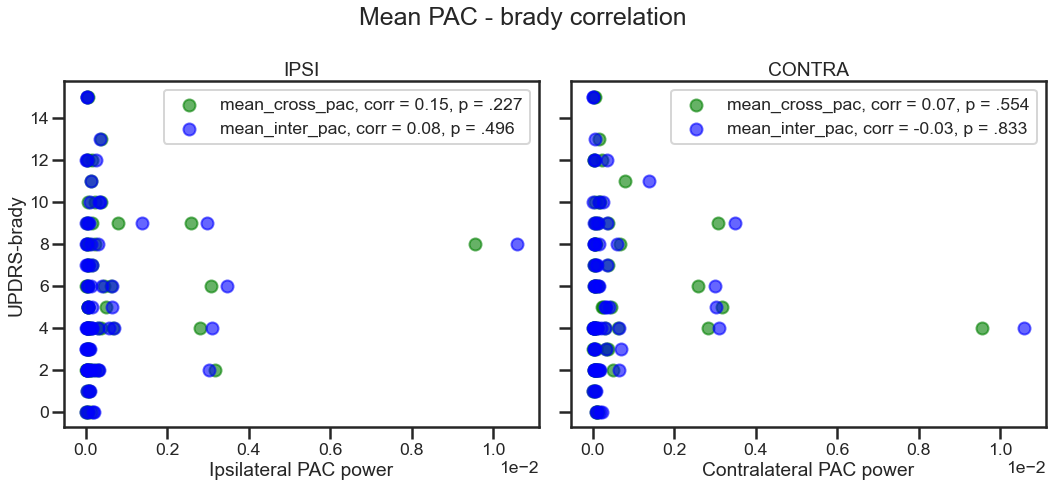

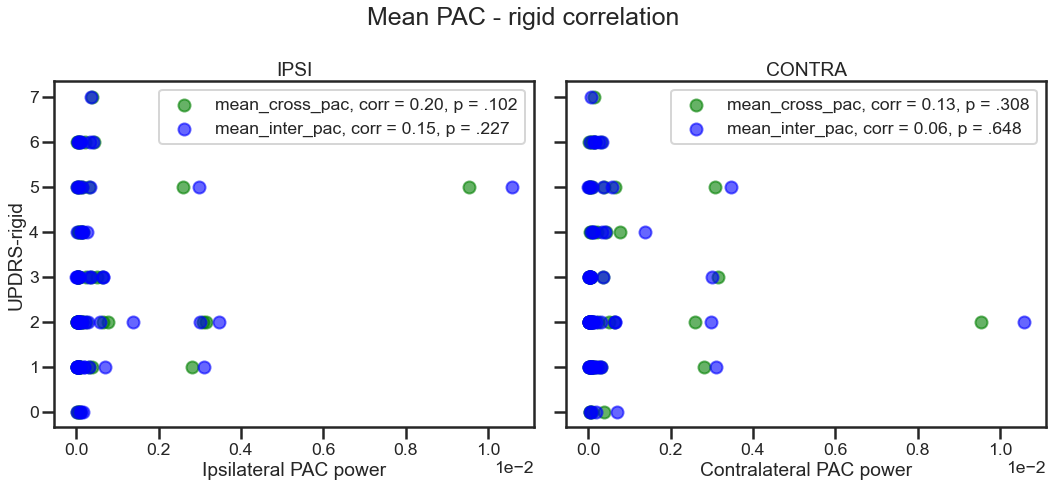

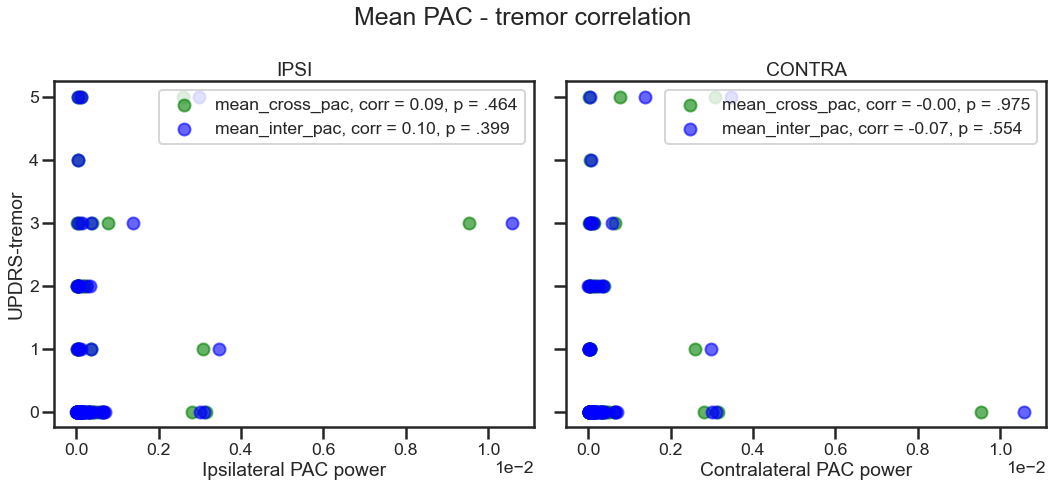

In [103]:
sns.set_context('poster', font_scale=0.8)
sns.color_palette('bright')

with open('../path_data.txt', 'r') as f:
    data_path = f.readline()
    
df = pd.read_csv("../data/clinics_with_pac.csv", sep=',', index_col=0)
df = df.dropna()

save_path = os.path.join(data_path, 'im_common', 'PAC and clinics correlation', 'both cross and inter')

try:
    os.makedirs(save_path)
except:
    pass


sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]


counter = 1

for symptom in ['brady', 'rigid', 'tremor']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    plt.suptitle(f"Mean PAC - {symptom} correlation ", fontsize=25)
    for pac_type, color in zip(['mean_cross_pac', 'mean_inter_pac'], ['green', 'blue']):

        """IPSILATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        
        ax = axes[0]
        title = f"IPSI"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Ipsilateral PAC power")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        """CONTRALATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        ax = axes[1]
        title = f"CONTRA"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Contralateral PAC power")
        #ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plt.tight_layout()
        
        fig_path = os.path.join(save_path, f"{counter}. MEAN PAC-{symptom}-corr.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
    plt.show()
    counter += 1

In [31]:
df.head()

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac
0,8,5,3,8,6,2,0.000064,0.000054,0.000503,0.000252,0.000289,0.000771,0.002129,0.001712
1,4,1,0,3,2,0,0.000029,0.000057,0.000112,0.000155,0.000434,0.001224,0.001155,0.001858
2,13,7,3,9,5,2,0.000303,0.000563,0.002055,0.001969,0.003234,0.003878,0.010972,0.011794
3,2,2,0,2,2,0,0.000071,0.000042,0.000408,0.000324,0.000492,0.000643,0.002797,0.002199
6,5,4,0,6,6,0,0.004402,0.004237,0.001014,0.000214,0.020389,0.025126,0.007771,0.003547


### No patient 4

А теперь выкинем Камалову

In [50]:
df_nop4 = df[~(df['patient'] == 'Patient4')]

In [36]:
df_nop4

,r_brady,r_rigid,r_tremor,l_brady,l_rigid,l_tremor,l_mean_inter_pac,l_mean_cross_pac,r_mean_inter_pac,r_mean_cross_pac,l_max_inter_pac,l_max_cross_pac,r_max_inter_pac,r_max_cross_pac,patient
0,8,5,3,8,6,2,0.000064,0.000054,0.000503,0.000252,0.000289,0.000771,0.002129,0.001712,Patient1
1,4,1,0,3,2,0,0.000029,0.000057,0.000112,0.000155,0.000434,0.001224,0.001155,0.001858,Patient1
2,13,7,3,9,5,2,0.000303,0.000563,0.002055,0.001969,0.003234,0.003878,0.010972,0.011794,Patient1
3,2,2,0,2,2,0,0.000071,0.000042,0.000408,0.000324,0.000492,0.000643,0.002797,0.002199,Patient1
6,5,4,0,6,6,0,0.004402,0.004237,0.001014,0.000214,0.020389,0.025126,0.007771,0.003547,Patient2
7,0,1,0,1,1,0,0.000221,0.000215,0.000117,0.000028,0.001319,0.001228,0.000411,0.000565,Patient2
8,3,6,0,2,5,0,0.002980,0.002310,0.000367,0.000259,0.019398,0.017537,0.002196,0.002184,Patient3
9,1,1,0,0,1,0,0.000017,0.000078,0.000287,0.000273,0.000258,0.001232,0.001421,0.001323,Patient3
10,12,4,2,10,6,2,0.001967,0.001178,0.001688,0.000864,0.010256,0.011837,0.013612,0.012063,Patient3
11,0,1,0,0,2,0,0.001106,0.000501,0.001068,0.000201,0.007126,0.005350,0.007023,0.003288,Patient3


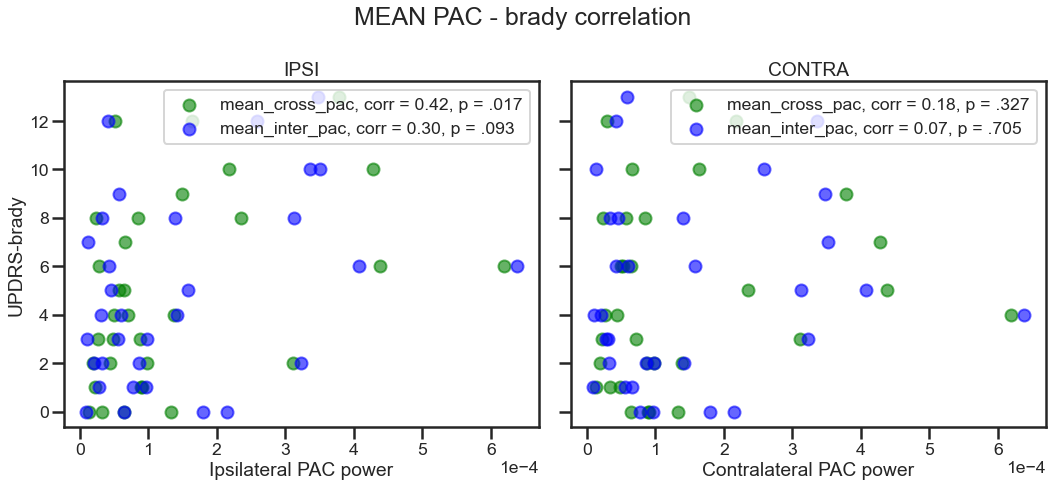

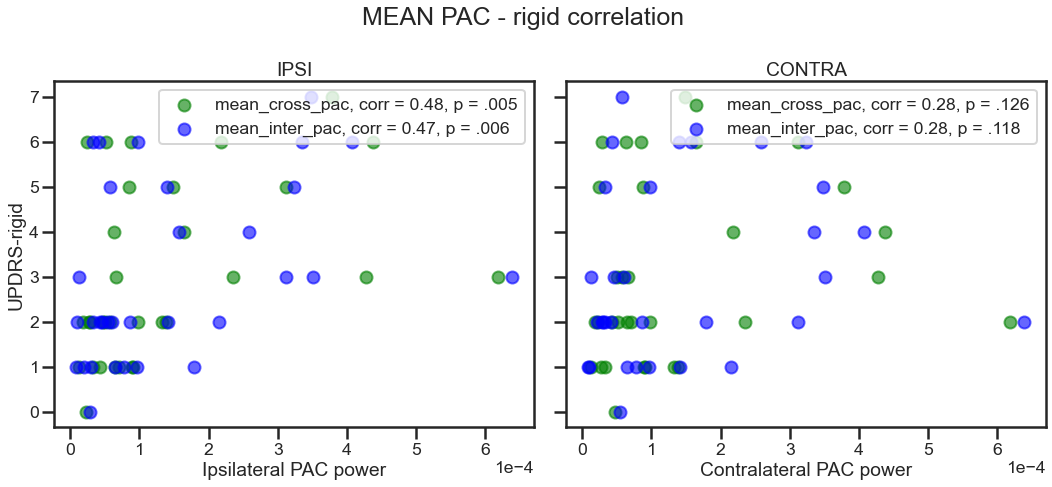

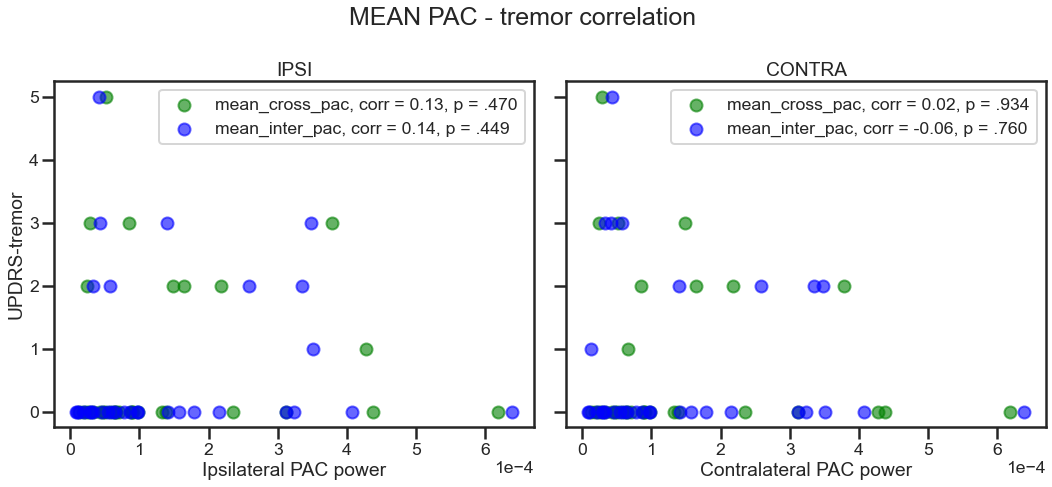

In [51]:
sns.set_context('poster', font_scale=0.8)
sns.color_palette('bright')

with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'PAC and clinics correlation', 'both cross and inter without P4')

try:
    os.makedirs(save_path)
except:
    pass


sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]


counter = 1

for symptom in ['brady', 'rigid', 'tremor']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    plt.suptitle(f"MEAN PAC - {symptom} correlation ", fontsize=25)
    for pac_type, color in zip(['mean_cross_pac', 'mean_inter_pac'], ['green', 'blue']):

        """IPSILATERAL"""
        x1 = df_nop4[f"{sides[0]}_{pac_type}"]
        y1 = df_nop4[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df_nop4[f"{sides[1]}_{pac_type}"]
        y2 = df_nop4[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        
        ax = axes[0]
        title = f"IPSI"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Ipsilateral PAC power")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        """CONTRALATERAL"""
        x1 = df_nop4[f"{sides[0]}_{pac_type}"]
        y1 = df_nop4[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df_nop4[f"{sides[1]}_{pac_type}"]
        y2 = df_nop4[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        ax = axes[1]
        title = f"CONTRA"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Contralateral PAC power")
        #ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plt.tight_layout()
        
        fig_path = os.path.join(save_path, f"{counter}. MEAN PAC-{symptom}-corr-noPatient4.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
    plt.show()
    counter += 1

## Max PAC - clinics correlation

### No patient 4

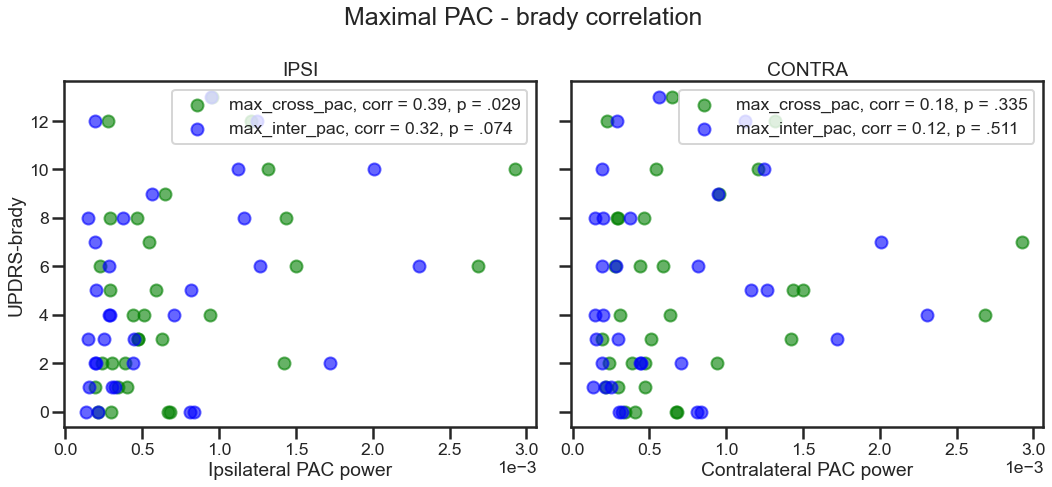

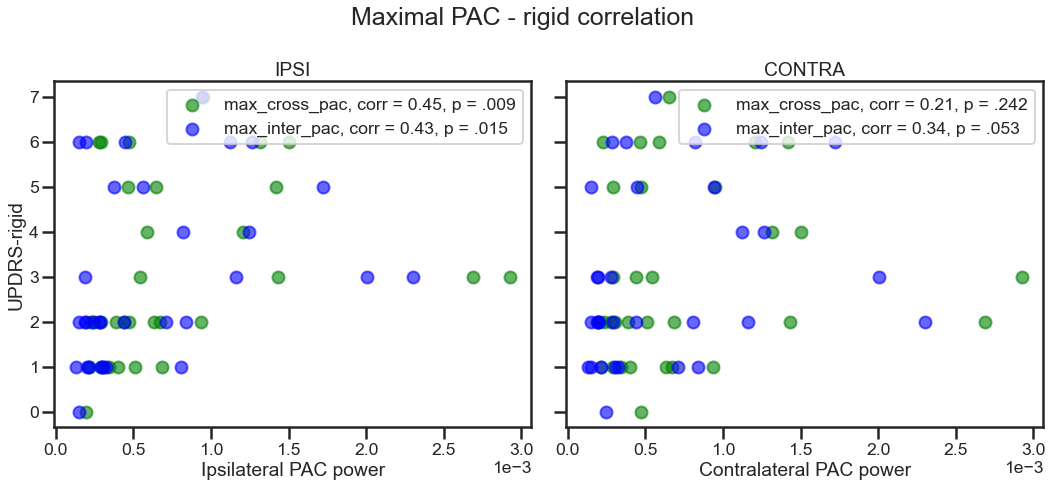

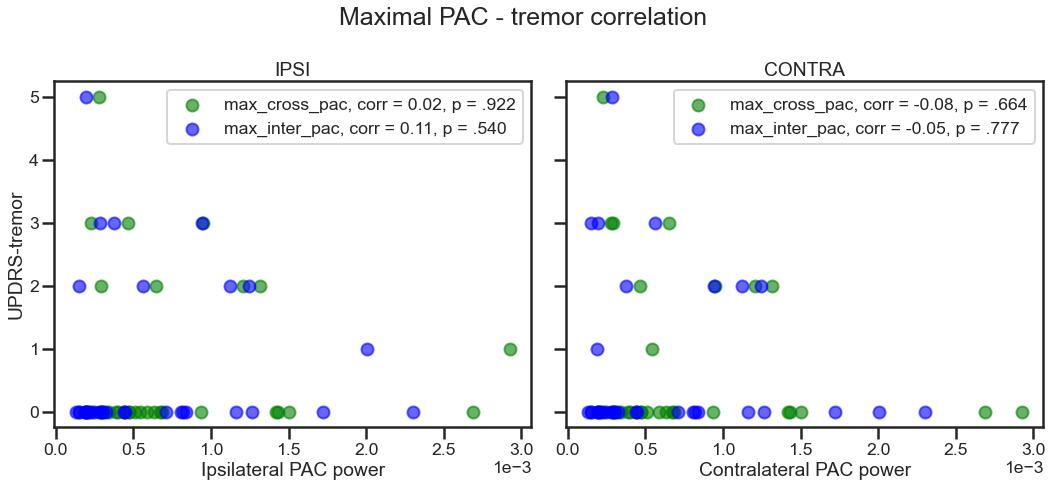

In [52]:
sns.set_context('poster', font_scale=0.8)
sns.color_palette('bright')

with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'PAC and clinics correlation', 'both cross and inter without P4')

try:
    os.makedirs(save_path)
except:
    pass


sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]


counter = 1

for symptom in ['brady', 'rigid', 'tremor']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    plt.suptitle(f"Maximal PAC - {symptom} correlation ", fontsize=25)
    for pac_type, color in zip(['max_cross_pac', 'max_inter_pac'], ['green', 'blue']):

        """IPSILATERAL"""
        x1 = df_nop4[f"{sides[0]}_{pac_type}"]
        y1 = df_nop4[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df_nop4[f"{sides[1]}_{pac_type}"]
        y2 = df_nop4[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        
        ax = axes[0]
        title = f"IPSI"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Ipsilateral PAC power")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        """CONTRALATERAL"""
        x1 = df_nop4[f"{sides[0]}_{pac_type}"]
        y1 = df_nop4[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df_nop4[f"{sides[1]}_{pac_type}"]
        y2 = df_nop4[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        ax = axes[1]
        title = f"CONTRA"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Contralateral PAC power")
        #ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plt.tight_layout()
        
        fig_path = os.path.join(save_path, f"{counter}. MAX PAC-{symptom}-corr_noPatient4.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
    plt.show()
    counter += 1

### With patient 4

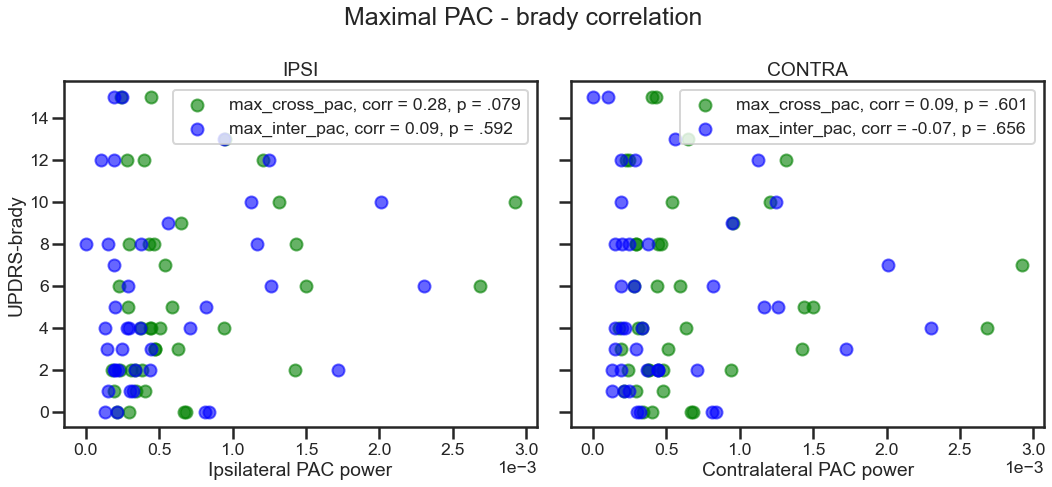

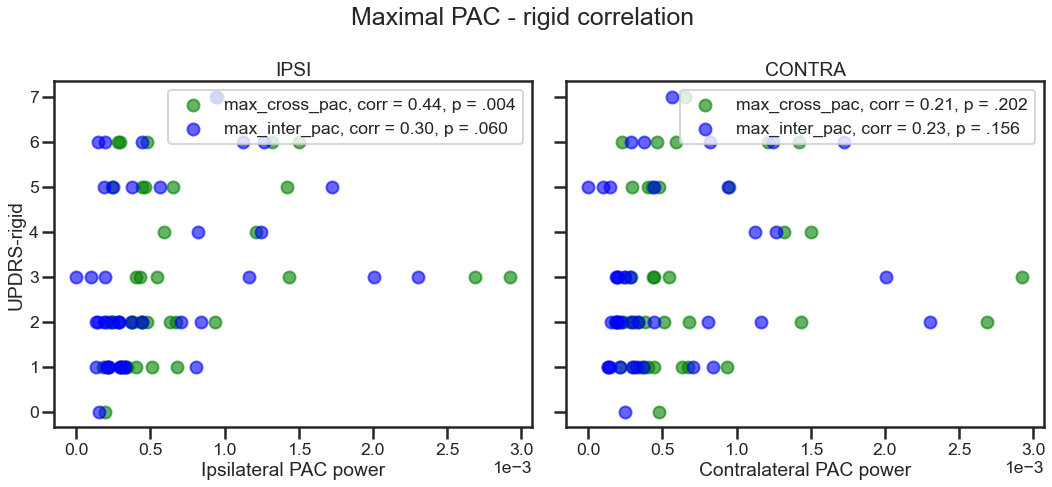

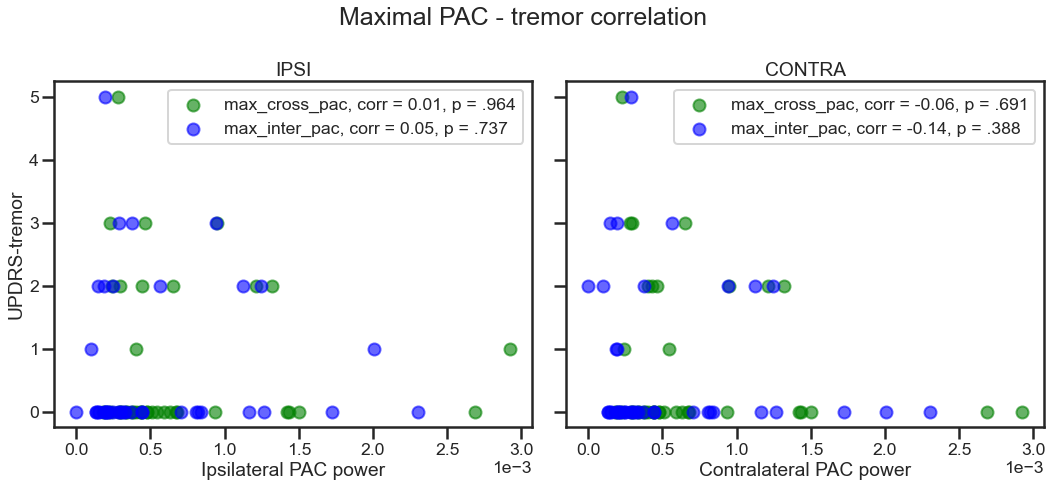

In [53]:
sns.set_context('poster', font_scale=0.8)
sns.color_palette('bright')

with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'PAC and clinics correlation', 'both cross and inter')

try:
    os.makedirs(save_path)
except:
    pass


sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]


counter = 1

for symptom in ['brady', 'rigid', 'tremor']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    plt.suptitle(f"Maximal PAC - {symptom} correlation ", fontsize=25)
    for pac_type, color in zip(['max_cross_pac', 'max_inter_pac'], ['green', 'blue']):

        """IPSILATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[0]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[1]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        
        ax = axes[0]
        title = f"IPSI"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Ipsilateral PAC power")
        ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        """CONTRALATERAL"""
        x1 = df[f"{sides[0]}_{pac_type}"]
        y1 = df[f"{sides[1]}_{symptom}"]
        # regardless of side, choose ipsilateral data
        x2 = df[f"{sides[1]}_{pac_type}"]
        y2 = df[f"{sides[0]}_{symptom}"]
        
        x = pd.concat((x1, x2), ignore_index=True)
        y = pd.concat((y1, y2), ignore_index=True)
        
        rho_p, pval_p = stats.pearsonr(x, y)
        rho_s, pval_s = stats.spearmanr(x, y)
        
        ax = axes[1]
        title = f"CONTRA"
        label = f"{pac_type}, corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
        ax.scatter(x, y, alpha=0.6, label=label, color=color)
        ax.legend(loc='upper right')
        ax.set_title(title)
        ax.set_xlabel(f"Contralateral PAC power")
        #ax.set_ylabel(f"UPDRS-{symptom}")
        
        ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
        
        plt.tight_layout()
        
        fig_path = os.path.join(save_path, f"{counter}. MAX PAC-{symptom}-corr.png")
        plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
    plt.show()
    counter += 1

## Mean beta-clinics correlation

In [12]:
df = df_clinics_with_pac.dropna()

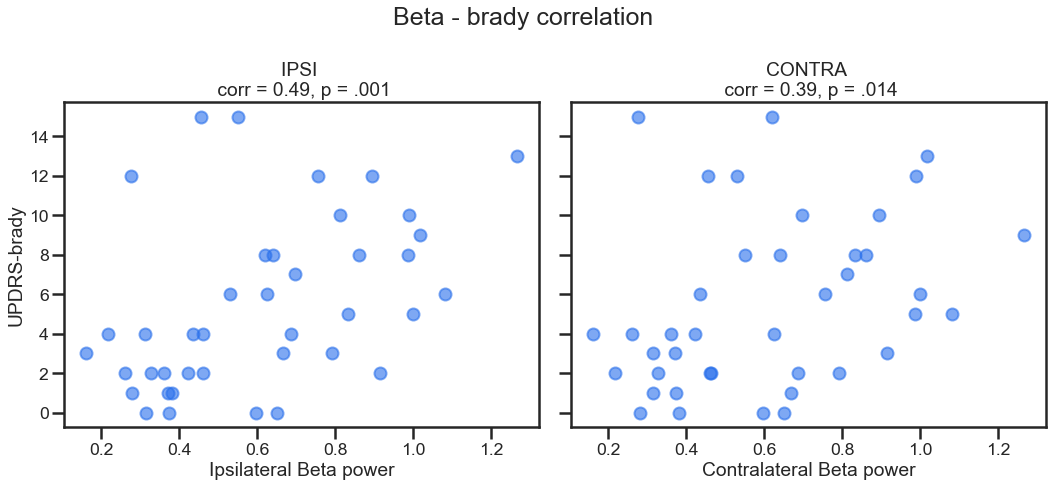

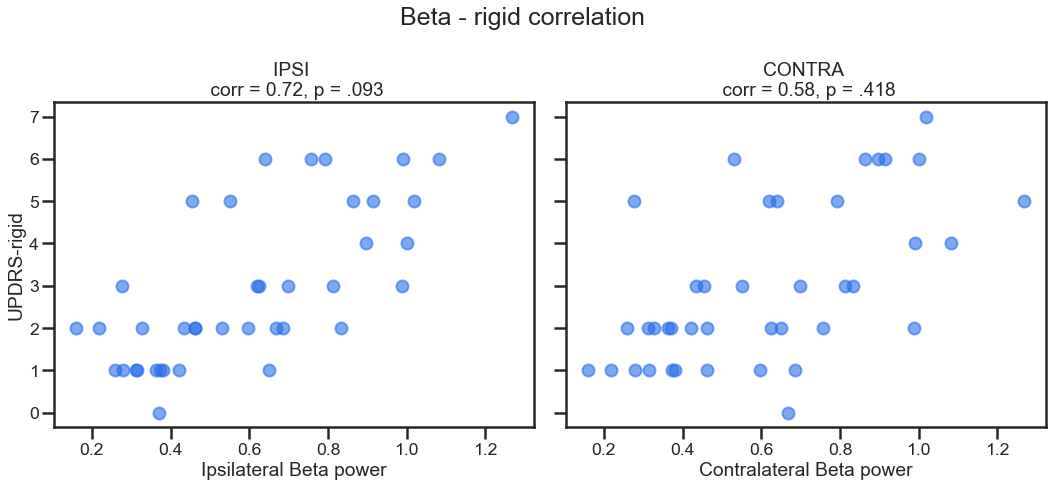

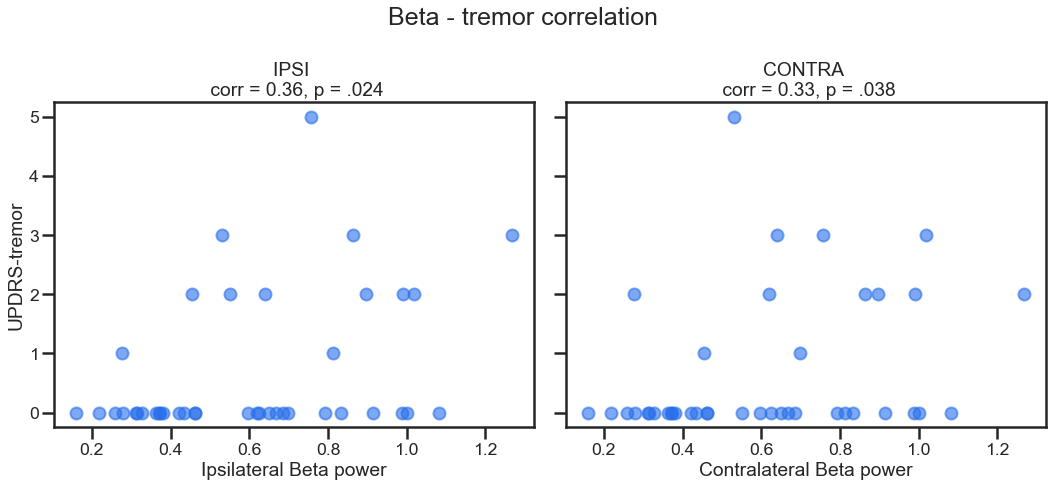

In [16]:
sns.set_context('poster', font_scale=0.8)
sns.color_palette('bright')

with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'Beta-clinics correlation')

try:
    os.makedirs(save_path)
except:
    pass


sides = ['l', 'r']
sides_titles = ["LEFT", "RIGHT"]
color = '#286feb'

counter = 1

for symptom in ['brady', 'rigid', 'tremor']:
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
    plt.suptitle(f"Beta - {symptom} correlation ", fontsize=25)

    """IPSILATERAL"""
    x1 = df[f"{sides[0]}_mean_beta"]
    y1 = df[f"{sides[0]}_{symptom}"]
    # regardless of side, choose ipsilateral data
    x2 = df[f"{sides[1]}_mean_beta"]
    y2 = df[f"{sides[1]}_{symptom}"]

    x = pd.concat((x1, x2), ignore_index=True)
    y = pd.concat((y1, y2), ignore_index=True)

    rho_p, pval_p = stats.pearsonr(x, y)
    rho_s, pval_s = stats.spearmanr(x, y)


    ax = axes[0]
    title = f"IPSI \n corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
    ax.scatter(x, y, alpha=0.6, color=color)
    #ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(f"Ipsilateral Beta power")
    ax.set_ylabel(f"UPDRS-{symptom}")

    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    """CONTRALATERAL"""
    x1 = df[f"{sides[0]}_mean_beta"]
    y1 = df[f"{sides[1]}_{symptom}"]
    # regardless of side, choose ipsilateral data
    x2 = df[f"{sides[1]}_mean_beta"]
    y2 = df[f"{sides[0]}_{symptom}"]

    x = pd.concat((x1, x2), ignore_index=True)
    y = pd.concat((y1, y2), ignore_index=True)

    rho_p, pval_p = stats.pearsonr(x, y)
    rho_s, pval_s = stats.spearmanr(x, y)

    ax = axes[1]
    title = f"CONTRA \n corr = {rho_s:.2f}, p = {str(pval_s)[1:5]}"
    ax.scatter(x, y, alpha=0.6, color=color)
    #ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(f"Contralateral Beta power")
    #ax.set_ylabel(f"UPDRS-{symptom}")

    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

    plt.tight_layout()

    fig_path = os.path.join(save_path, f"{counter}. Beta-{symptom}-corr.png")
    plt.savefig(fig_path, bbox_inches='tight', dpi=150)
        
    plt.show()
    counter += 1